In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [5]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [6]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [7]:
#Horrible. Querer predecir el precio solo con el precio
series = df['close'].values.reshape(-1, 1)
print(series)

[[28.185]
 [28.07 ]
 [28.13 ]
 ...
 [54.69 ]
 [55.61 ]
 [54.46 ]]


In [0]:
#normalizo aprox
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [9]:
#Lo convierto a un X de series

T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print(X[0])
print("X.shape", X.shape, "Y.shape", Y.shape)

[[-1.62500489]
 [-1.64174953]
 [-1.6330132 ]
 [-1.66431839]
 [-1.68470317]
 [-1.77279453]
 [-1.76478623]
 [-1.84778139]
 [-1.84486928]
 [-1.78517101]]
X.shape (1249, 10, 1) Y.shape (1249,)


In [10]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 0s 23ms/step - loss: 0.1039 - val_loss: 0.0536
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0272
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0255
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0302
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0206
Epoch 6/80
20/20 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0226
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0243
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0205
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0223
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0445
Epoch 11/80
20/20 

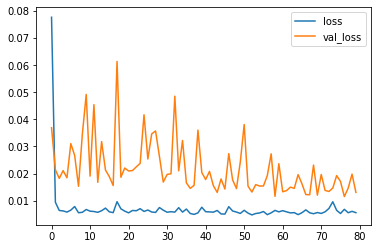

In [0]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


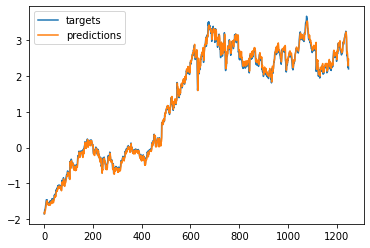

In [0]:

outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

#Resultados irreales por que predicciones se usan. Es un 1 step forcast

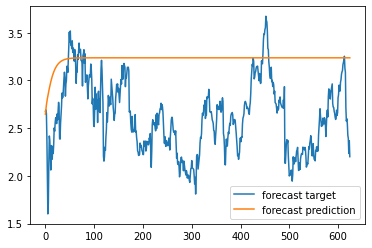

In [0]:
#Con varios steps
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

#Resultado coherente. Copia resultados anteriores, una especie de mean en la funcion. 

In [0]:
# ordeno bien los datos para que sean coherentes
df['PrevClose'] = df['close'].shift(1) # 1 para arriba

# queda asi
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [18]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [0]:
# calculo el return (es lo que sirve para ver cuanto rindio el stock)
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [20]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


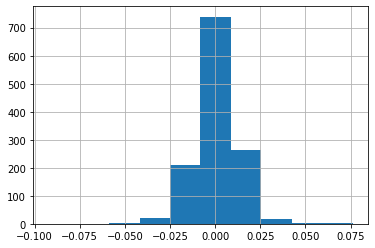

In [21]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [0]:
series = df['Return'].values[1:].reshape(-1, 1)

# normalizo mas o menos.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [23]:
#lo mismo 
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) #N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [24]:
### con lstm
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

#
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 0s 20ms/step - loss: 1.0010 - val_loss: 1.1444
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9881 - val_loss: 1.1355
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9831 - val_loss: 1.1428
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9879 - val_loss: 1.1561
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9835 - val_loss: 1.1409
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9846 - val_loss: 1.1482
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9867 - val_loss: 1.1431
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9835 - val_loss: 1.1451
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9810 - val_loss: 1.1468
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9819 - val_loss: 1.1475
Epoch 11/80
20/20 

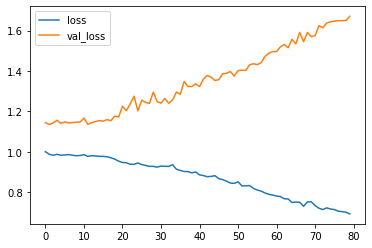

In [25]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


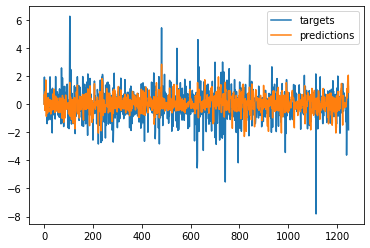

In [26]:
# 1 - step (no sirve para nada)
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

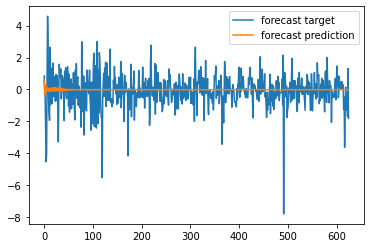

In [29]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

#osea no tiene ni idea que esta pasando. Copia el valor anterior, en vez de predecirlo. 

In [0]:
# lo que quiero en realidad es el return -> Vfinal - Vinicial / Vinicial. Lo que intento predecir es si sube o baja
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [0]:
#armo bien los datos
T = 10 
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [0]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [0]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [0]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [0]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [34]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 0s 17ms/step - loss: 0.6987 - accuracy: 0.4863 - val_loss: 0.6930 - val_accuracy: 0.5146
Epoch 2/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.5232 - val_loss: 0.6954 - val_accuracy: 0.4854
Epoch 3/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5089 - val_loss: 0.6959 - val_accuracy: 0.4854
Epoch 4/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5137 - val_loss: 0.6946 - val_accuracy: 0.4902
Epoch 5/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5244 - val_loss: 0.6945 - val_accuracy: 0.4951
Epoch 6/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5185 - val_loss: 0.6914 - val_accuracy: 0.5561
Epoch 7/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5256 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/300


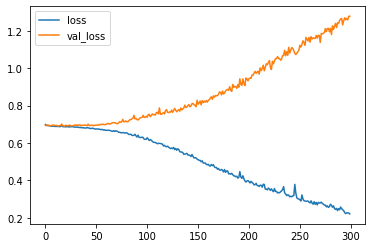

In [35]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

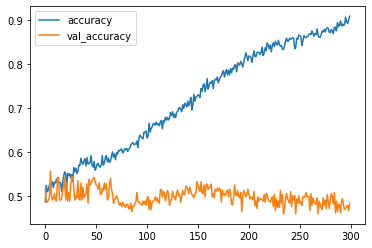

In [36]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()